# Installation

In [1]:
!pip uninstall -y gensim
!pip install gensim==4.1.2
!pip install torchdata
!pip install flair
!pip install nlpaug
!pip install sacremoses

!pip install gdown==4.4
!gdown https://drive.google.com/uc?id=1v4JA7gvNWoLT1Kxj-1D0JtOXCOOanldJ
!mv '/content/GoogleNews-vectors-negative300 (1).bin.gz' /content/GoogleNews-vectors-negative300.bin.gz
!gzip -d /content/GoogleNews-vectors-negative300.bin.gz

Found existing installation: gensim 3.6.0
Uninstalling gensim-3.6.0:
  Successfully uninstalled gensim-3.6.0
     |████████████████████████████████| 24.1 MB 1.6 MB/s 
     |████████████████████████████████| 47 kB 2.0 MB/s 
     |████████████████████████████████| 138 kB 9.0 MB/s 
     |████████████████████████████████| 127 kB 40.6 MB/s 
  Attempting uninstall: urllib3
    Found existing installation: urllib3 1.24.3
    Uninstalling urllib3-1.24.3:
      Successfully uninstalled urllib3-1.24.3
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
datascience 0.10.6 requires folium==0.2.1, but you have folium 0.8.3 which is incompatible.
     |████████████████████████████████| 402 kB 5.3 MB/s 
     |████████████████████████████████| 4.2 MB 40.4 MB/s 
     |████████████████████████████████| 84 kB 3.1 MB/s 
     |████████████████████████████████| 981 kB 36.0 MB/s 
     |█

# Imports

In [1]:
# Math
import torch
import numpy as np

# Flair Device
import flair
flair.device = torch.device('cuda')

# Analysis
import matplotlib.pyplot as plt
from tqdm import tqdm, trange

# Downloading Packages
import nltk
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('omw-1.4')
nltk.download('averaged_perceptron_tagger')
nltk.download('stopwords')

# Autoencoder and Dataset Preparation
from data.imdb_preparation import IMDB_preparation
from data.ag_news_preparation import AG_NEWS_preparation
from autoencoders.autoencoder import Autoencoder

[nltk_data] Downloading package punkt to /home/bodo/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /home/bodo/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /home/bodo/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /home/bodo/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package stopwords to /home/bodo/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


# 1. Vanilla Autoencoder

## 1.1 Loading Data

In [4]:
ds = AG_NEWS_preparation()

Preparing sentences...


100%|██████████| 120000/120000 [04:53<00:00, 408.77it/s]


Making sentences...


100%|██████████| 120000/120000 [01:39<00:00, 1206.38it/s]


Embedding sentences...


100%|██████████| 120000/120000 [01:08<00:00, 1741.91it/s]


Splitting sentences...


100%|██████████| 120000/120000 [00:05<00:00, 21109.60it/s]

Done!


In [5]:
ds_train, ds_valid = torch.utils.data.random_split(ds, [len(ds) - 1000, 1000])

In [6]:
dl_train = torch.utils.data.DataLoader(ds_train, batch_size=32, shuffle=True)
dl_valid = torch.utils.data.DataLoader(ds_valid, batch_size=32, shuffle=True)

## 1.2 Training loop

In [7]:
m = Autoencoder(100,100,100,4,3,variational=False, max_log2len=8)
Ls_train = []
Ls_valid = []
device = 'cuda'
m = m.to(device)

In [8]:
opt = torch.optim.Adamax(m.parameters(), lr=0.001, weight_decay=0.0001)

In [9]:
m = m.train()
EPOCHS = 12
for e in range(EPOCHS):
    print(f"Epoch: {e}")
    m = m.train()
    pbar = tqdm(dl_train)
    for i, (x_in, x_out) in enumerate(pbar):
        opt.zero_grad()
        x_in = x_in.to(device)
        x_out = x_out.to(device)
        mx = m(x_in)
        L = (mx - x_out).pow(2).sum((1,2)).mean()
        L.backward()
        opt.step()
    
        pbar.set_description(f"L: {L.item()}")
        Ls_train.append(L.item())
    
    with torch.no_grad():
        m = m.eval()
        pbar = tqdm(dl_valid)
        for i, (x_in, x_out) in enumerate(pbar):
            x_in = x_in.to(device)
            x_out = x_out.to(device)
            mx = m(x_in)
            L = (mx - x_out).pow(2).sum((1,2)).mean()
            pbar.set_description(f"VL: {L.item()}")
            Ls_valid.append(L.item())

Epoch: 0


VL: 192.26478576660156: 100%|██████████| 32/32 [00:01<00:00, 30.78it/s]


Epoch: 1


VL: 176.50143432617188: 100%|██████████| 32/32 [00:01<00:00, 31.51it/s]


Epoch: 2


VL: 157.00880432128906: 100%|██████████| 32/32 [00:01<00:00, 31.34it/s]


Epoch: 3


VL: 118.17205810546875: 100%|██████████| 32/32 [00:01<00:00, 30.02it/s]


Epoch: 4


VL: 139.7663116455078: 100%|██████████| 32/32 [00:01<00:00, 30.98it/s]


Epoch: 5


VL: 152.4093017578125: 100%|██████████| 32/32 [00:01<00:00, 29.93it/s]


Epoch: 6


VL: 104.23878479003906: 100%|██████████| 32/32 [00:01<00:00, 30.83it/s]


Epoch: 7


VL: 126.68508911132812: 100%|██████████| 32/32 [00:01<00:00, 30.60it/s]


Epoch: 8


VL: 129.4539337158203: 100%|██████████| 32/32 [00:01<00:00, 30.93it/s]


Epoch: 9


VL: 118.00404357910156: 100%|██████████| 32/32 [00:01<00:00, 30.96it/s]


Epoch: 10


VL: 124.73020935058594: 100%|██████████| 32/32 [00:01<00:00, 31.33it/s]


Epoch: 11


VL: 82.97929382324219: 100%|██████████| 32/32 [00:01<00:00, 31.64it/s]


In [10]:
torch.save(({'train': Ls_train, 'valid':Ls_valid}, m.state_dict()), 'vanilla_6_AG_News.pt')

In [2]:
losses, _ = torch.load('vanilla_6_AG_News.pt')

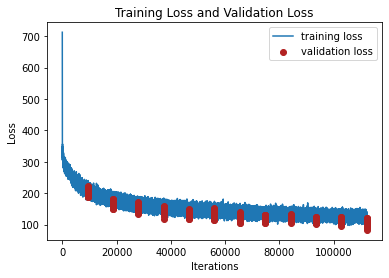

In [3]:
plt.plot(losses['train'], label='training loss')
for i in range(12):
    plt.scatter(
        [(i+1)*9349 for _ in range(32)],
        losses['valid'][i*32:(i+1)*32],
        zorder=3,
        c='firebrick',
        label='validation loss' if i == 0 else ''
    )
plt.title('Training Loss and Validation Loss')
plt.xlabel('Iterations')
plt.ylabel('Loss')
plt.legend()

The traing of AG_NEWS has higher variance for batches. The training is slow, but the loss decreases. Importantly, the MSE loss for the vanilla autoencoder is lower than for the VAE and DAE. Despite that, as for the IMDB, the validation loss closely matches the training loss.